# **Assignment 6 PART B**

### Arpitha Gurumurthy

Implementing a CNN based flower image classifier from a custom data set using Keras.

## **Data Collection**
Downloading the dataset from images.google.com to create a custom dataset. Creating a dataset of flowers - roses, dandelions and lilies.

A multiclass classification with 3 target values.

Loading the images onto the drive and mounting it to use it in our colab.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from fastai.vision import *

In [ ]:
%cd /content/gdrive/My Drive/258_HW6

/content/gdrive/My Drive/258_HW6


## **Roses**

In [ ]:
#One time run
# dest = Path('roses')
# dest.mkdir(exist_ok=True)

In [ ]:
#One time run
# download_images('/content/gdrive/My Drive/258_HW6/roses/roses_google.csv','roses',max_workers=0)

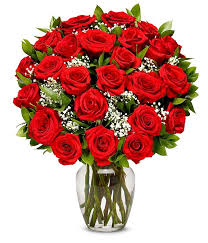

In [ ]:
from IPython.display import Image
Image('roses/00000049.jpg')

## **Dandelions**

In [ ]:
#One time run
# dest = Path('dandelions')
# dest.mkdir(exist_ok=True)

In [ ]:
#One time run
# download_images('/content/gdrive/My Drive/258_HW6/dandelions/dandelions_google.csv','dandelions',max_workers=0)

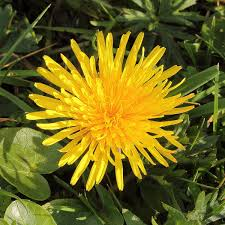

In [ ]:
from IPython.display import Image
Image('dandelions/00000051.jpg')

## **Lilies**

In [ ]:
#One time run
# dest = Path('lilies')
# dest.mkdir(exist_ok=True)

In [ ]:
#One time run
#download_images('/content/gdrive/My Drive/258_HW6/lilies/lilies_google.csv','lilies',max_workers=0)

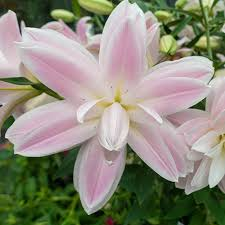

In [ ]:
from IPython.display import Image
Image('lilies/00000049.jpg')

# **Implementation using tensorflow**

In [ ]:
##Importing the necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!pwd

/content/gdrive/My Drive/258_HW6


In [ ]:
rm -rf `find -type d -name .ipynb_checkpoints`

Filtering out the corrupted images
When working with lots of real-world image data, corrupted images are a common occurence. Filtering out the badly-encoded images that do not feature the string "JFIF" in their header.



In [ ]:
import os

num_skipped = 0
for folder_name in ("lilies", "roses", "dandelions"):
    folder_path = os.path.join("/content/gdrive/My Drive/258_HW6", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


## **Generating a Dataset**

In [ ]:
##Image resolution
image_size = (180, 180)
##The batch size is a number of samples processed before the model is updated. 
##The number of epochs is the number of complete passes through the training dataset. 
##The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/My Drive/258_HW6",
    validation_split=0.1,
    subset="training",
    ##Seed helps get predictable, repeatable results every time. 
    ##If we do not set the seed, then we get different random numbers at every invocation
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/My Drive/258_HW6",
    validation_split=0.1,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 956 files belonging to 3 classes.
Using 861 files for training.
Found 956 files belonging to 3 classes.
Using 95 files for validation.


## **Visualizing the data**

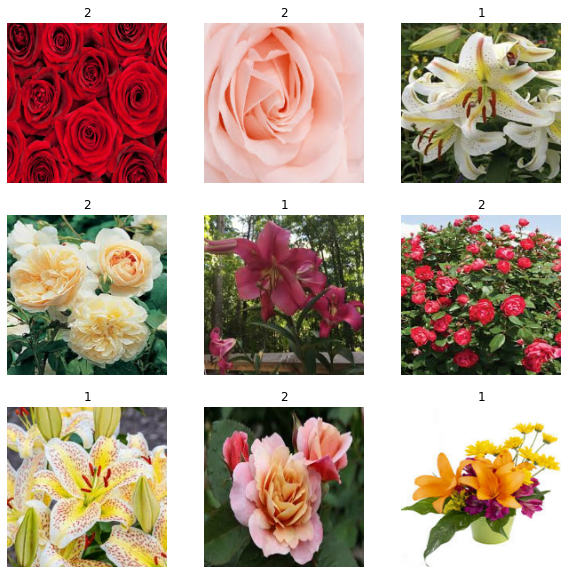

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## **Using image data augmentation**
When we don't have a large image dataset, we can artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.



In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

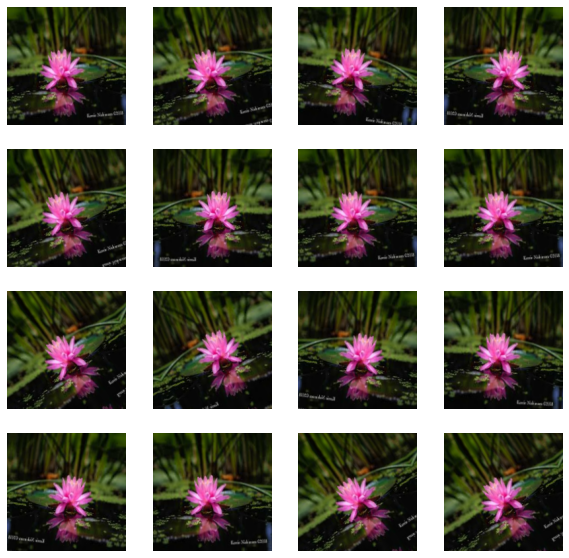

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(16):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_images[10].numpy().astype("uint8"))
        plt.axis("off")

## **Standardizing the data**
Image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.



In [ ]:
# augmented_train_ds = train_ds.map(
#   lambda x, y: (data_augmentation(x, training=True), y))

## **Configuring the dataset for performance**
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## **Building a model**
We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using Keras Tuner.

Note that:

We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
We include a Dropout layer before the final classification layer.


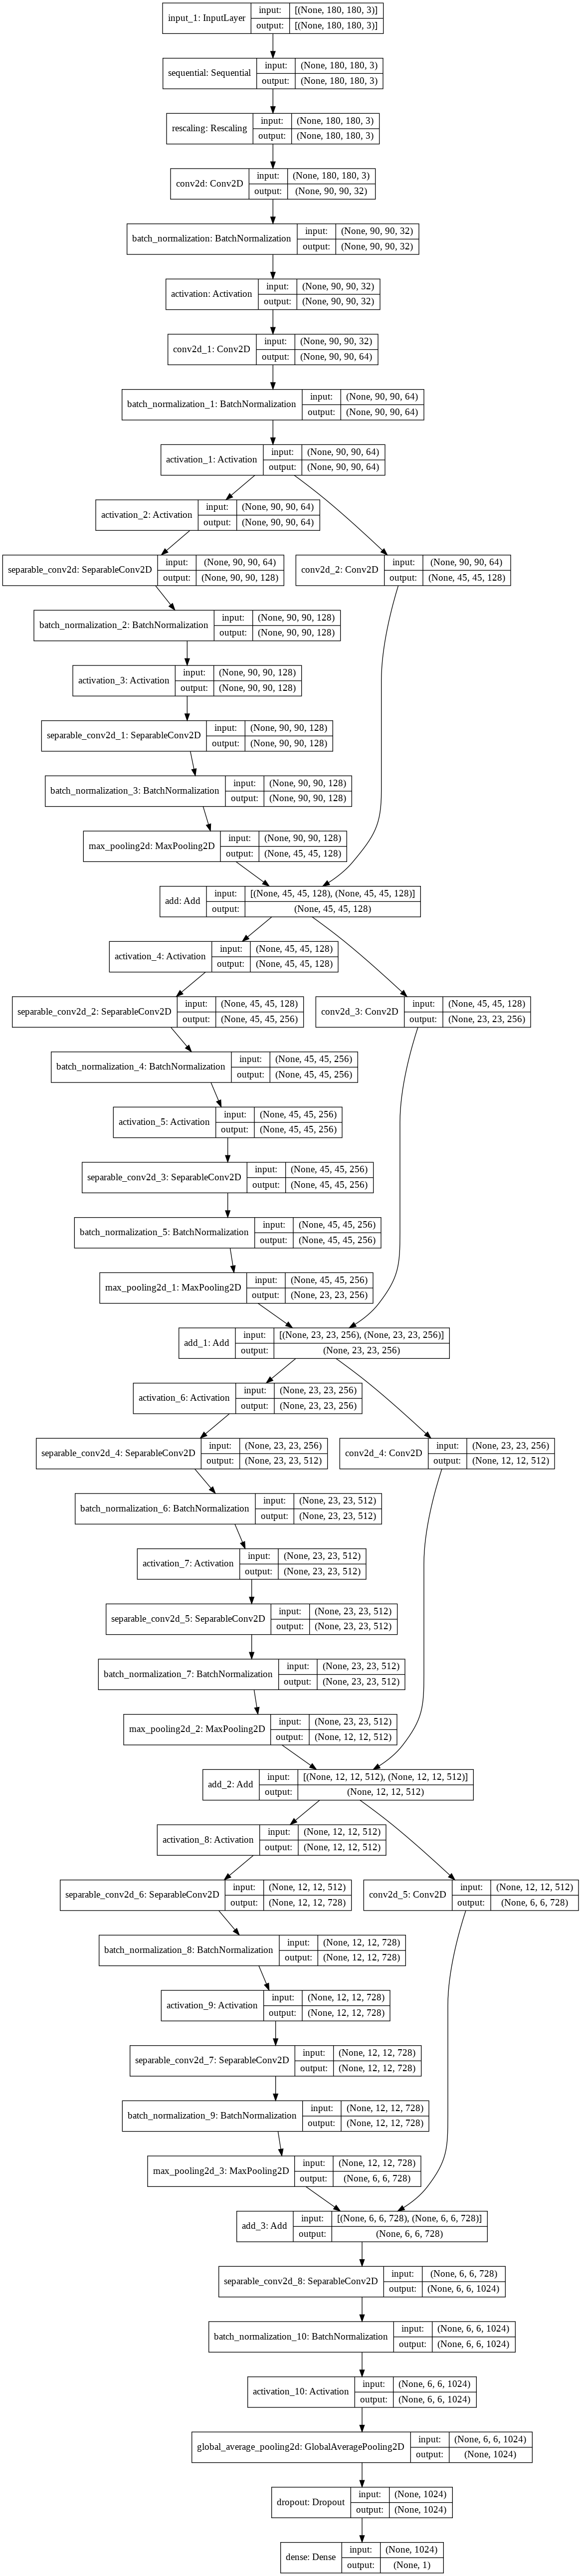

In [ ]:
def make_model(input_shape, num_classes):
    
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 3:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

## **Training the model**

In [ ]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds
)

Epoch 1/5
27/27 [==============================] - 264s 9s/step - loss: 0.0000e+00 - accuracy: 0.5324 - val_loss: 0.0000e+00 - val_accuracy: 0.2526
Epoch 2/5
27/27 [==============================] - 201s 7s/step - loss: 0.0000e+00 - accuracy: 0.5234 - val_loss: 0.0000e+00 - val_accuracy: 0.2526
Epoch 3/5
27/27 [==============================] - 200s 7s/step - loss: 0.0000e+00 - accuracy: 0.5214 - val_loss: 0.0000e+00 - val_accuracy: 0.2526
Epoch 4/5
27/27 [==============================] - 201s 7s/step - loss: 0.0000e+00 - accuracy: 0.5386 - val_loss: 0.0000e+00 - val_accuracy: 0.2526
Epoch 5/5
27/27 [==============================] - 200s 7s/step - loss: 0.0000e+00 - accuracy: 0.5472 - val_loss: 0.0000e+00 - val_accuracy: 0.2526


## **Running inference on new data**

In [ ]:
img = keras.preprocessing.image.load_img(
    "lilies/00000049.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(score)


[4.574119e-08]
